In [1]:
# data manipulation and plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# for saving the pipeline
import joblib

# from Scikit-learn
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, Binarizer
from sklearn.feature_selection import SelectFromModel

# from feature-engine
from feature_engine.imputation import (
    AddMissingIndicator,
    MeanMedianImputer,
    CategoricalImputer,
)

from feature_engine.encoding import (
    RareLabelEncoder,
    OrdinalEncoder,
)

from feature_engine.transformation import LogTransformer

from feature_engine.selection import DropFeatures
from feature_engine.wrappers import SklearnTransformerWrapper

import custom_preprocessors as pp

In [2]:
#load data
data_features = pd.read_csv("/Users/afanzott/Documents/RHI_Data_Science/research_notebooks/data/md_raw_dataset.csv", sep=";", index_col=False)
target = pd.read_csv("/Users/afanzott/Documents/RHI_Data_Science/research_notebooks/data/md_target_dataset.csv", sep=";")

#rename first column
data_features.rename(columns = {"Unnamed: 0":"index"}, inplace=True)
data_features.groups = data_features.groups.astype("int64", errors="ignore")

#merge both tables wrt groups & index
data_features = data_features.loc[~data_features.groups.isnull(), :]
data = pd.merge(data_features, target, how="inner", on=["groups","index"])

data.head()

,index,when,super_hero_group,tracking,place,tracking_times,crystal_type,Unnamed: 7,human_behavior_report,human_measure,...,reported_on_tower,opened,chemical_x,raw_kryptonite,argon,pure_seastone,crystal_supergroup,Cycle,groups,target
0,1,09/07/2020,D,84941,1,1,group 56,1,4,700,...,09/07/2020 15:53,44021.6737,21.966667,3570.0,0.0,99.94,0,2ª,0.0,1.233766
1,2,09/07/2020,D,84951,1,1,group 56,2,4,800,...,09/07/2020 16:54,44021.70867,21.166667,7950.0,0.0,91.49,0,2ª,0.0,2.467532
2,3,09/07/2020,D,84971,1,1,group 56,7,3,700,...,09/07/2020 18:55,09/07/2020 19:02,15.250000,807.0,0.0,NaN,0,2ª,0.0,3.701299
3,4,09/07/2020,D,84981,1,1,group 27,17,3,700,...,09/07/2020 19:47,09/07/2020 20:20,20.566667,NaN,0.0,509.19,0,2ª,0.0,4.935065
4,5,09/07/2020,B,84991,1,1,group 56,12,3,720,...,09/07/2020 21:51,09/07/2020 22:09,32.016667,1026.0,0.0,127.79,0,2ª,0.0,6.168831


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['target'], axis=1), # predictive variables
    data['target'], # target
    test_size=0.1, # portion of dataset to allocate to test set
    random_state=0, # we are setting the seed here
)

X_train.shape, X_test.shape

((7689, 35), (855, 35))

In [4]:
y_train = np.log(y_train)
y_test = np.log(y_test)

In [5]:
#Cast etherium as numeric

X_train.etherium_before_start = pd.to_numeric(X_train.etherium_before_start, errors="coerce")
X_test.etherium_before_start = pd.to_numeric(X_test.etherium_before_start, errors="coerce")

cat_vars = [var for var in X_train.columns if X_train[var].dtype == "O"]

cat_vars = cat_vars + ["index", "place", "Unnamed: 7", "human_behavior_report", "groups", "tracking_times"]

# cast all variables as categorical
X_train[cat_vars] = X_train[cat_vars].astype('O')
X_test[cat_vars] = X_test[cat_vars].astype('O')

# Configuration

In [7]:
#variables with na
NUMERICAL_VARS_WITH_NA = ['crystal_weight', 'first_factor_x', 'final_factor_x', 'previous_adamantium', 'Unnamed: 17',
                        'etherium_before_start', 'chemical_x', 'raw_kryptonite', 'argon', 'pure_seastone', 'diff_subprocess1',
                        'diff_expected', 'diff_process', 'year_start_critical_subprocess1', 'month_start_critical_subprocess1',
                        'day_start_critical_subprocess1', 'hour_start_critical_subprocess1', 'minute_start_critical_subprocess1',
                        'second_start_critical_subprocess1', 'year_reported_on_tower', 'month_reported_on_tower', 'day_reported_on_tower',
                        'hour_reported_on_tower', 'minute_reported_on_tower', 'second_reported_on_tower', 'year_opened', 'month_opened',
                        'day_opened', 'hour_opened', 'minute_opened', 'second_opened']

#variables to temporal transform step1
TEMPORAL_VARS_STEP1 = ["when", "expected_start", "start_process", "start_subprocess1",
                "start_critical_subprocess1", "predicted_process_end", "process_end",
                "subprocess1_end", "reported_on_tower", "opened"]

#variables to temporal transform step2 
TEMPORAL_VARS_STEP2_1 = ["diff_subprocess1", "subprocess1_end", "start_subprocess1"]
TEMPORAL_VARS_STEP2_2 = ["diff_expected", "predicted_process_end", "expected_start"]
TEMPORAL_VARS_STEP2_3 = ["diff_process", "process_end", "start_process"]

#variables to temporal transform step3 
TEMPORAL_VARS_STEP3_DATE = ["when"]
TEMPORAL_VARS_STEP3_DATETIME = ["start_critical_subprocess1", "reported_on_tower", "opened"]

# variables to log transform
NUMERICALS_LOG_VARS = ["crystal_weight", "chemical_x", "final_factor_x", "pure_seastone"]

# categorical variables to encode
CATEGORICAL_VARS = ["super_hero_group", "crystal_type", "Cycle"]

#Params from Hyperparameter Tuning
PARAMS = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.1,
    "loss": "squared_error",
    "verbose": 5
}

In [8]:
# set up the pipeline
target_Val = Pipeline([

    # == TEMPORAL VARIABLES ====
    ('temp_var_step1', pp.TempVarMissingTransformer(
        temp_vars=TEMPORAL_VARS_STEP1)),

    ('temp_var_step2_1', pp.TempVarElapsedTimeTransformer(
        name=TEMPORAL_VARS_STEP2_1[0], var1=TEMPORAL_VARS_STEP2_1[1], var2=TEMPORAL_VARS_STEP2_1[2])),
    ('temp_var_step2_2', pp.TempVarElapsedTimeTransformer(
        name=TEMPORAL_VARS_STEP2_2[0], var1=TEMPORAL_VARS_STEP2_2[1], var2=TEMPORAL_VARS_STEP2_2[2])),
    ('temp_var_step2_3', pp.TempVarElapsedTimeTransformer(
        name=TEMPORAL_VARS_STEP2_3[0], var1=TEMPORAL_VARS_STEP2_3[1], var2=TEMPORAL_VARS_STEP2_3[2])),
    
    ('temp_var_step3_date', pp.TempVarSplitTransformer(
        vars=TEMPORAL_VARS_STEP3_DATE, date_or_dt="date")),
    ('temp_var_step3_datetime', pp.TempVarSplitTransformer(
        vars=TEMPORAL_VARS_STEP3_DATETIME, date_or_dt="datetime")),
    
    # ===== IMPUTATION =====
    # add missing indicator
    ('missing_indicator', AddMissingIndicator(variables=NUMERICAL_VARS_WITH_NA)),

    # impute numerical variables with the mean
    ('mean_imputation', MeanMedianImputer(
        imputation_method='mean', variables=NUMERICAL_VARS_WITH_NA
    )),

    # ==== VARIABLE TRANSFORMATION =====
    ('log', LogTransformer(variables=NUMERICALS_LOG_VARS)),
       
   # == CATEGORICAL ENCODING
    ('rare_label_encoder', RareLabelEncoder(
        tol=0.01, n_categories=1, variables=CATEGORICAL_VARS
    )),

    # encode categorical and discrete variables using the target mean
    ('categorical_encoder', OrdinalEncoder(
        encoding_method='ordered', variables=CATEGORICAL_VARS)),

    # ==== SCALING VARIABLES TRANSFORMATION =====
    ('scaler', MinMaxScaler()),

    # ==== VARIABLE SELECTION =====
    ('selector', SelectFromModel(Lasso(alpha=0.001, random_state=0))),
    ('GBM', GradientBoostingRegressor(**PARAMS, random_state=0)),
])

In [9]:
target_Val.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           0.7314            8.65s
         2           0.6004            8.45s
         3           0.4940            8.41s
         4           0.4076            8.38s
         5           0.3373            8.38s
         6           0.2801            8.36s
         7           0.2337            8.32s
         8           0.1959            8.30s
         9           0.1652            8.28s
        10           0.1403            8.24s
        11           0.1198            8.22s
        12           0.1032            8.20s
        13           0.0897            8.16s
        14           0.0786            8.13s
        15           0.0693            8.10s
        16           0.0618            8.07s
        17           0.0557            8.03s
        18           0.0505            8.00s
        19           0.0464            7.96s
        20           0.0429            7.93s
        21           0.0398            7.89s
        2

Pipeline(steps=[('temp_var_step1',
                 TempVarMissingTransformer(temp_vars=['when', 'expected_start',
                                                      'start_process',
                                                      'start_subprocess1',
                                                      'start_critical_subprocess1',
                                                      'predicted_process_end',
                                                      'process_end',
                                                      'subprocess1_end',
                                                      'reported_on_tower',
                                                      'opened'])),
                ('temp_var_step2_1',
                 TempVarElapsedTimeTransformer(name='diff_subprocess1',
                                               var1='subprocess1_end',
                                               var2=...
                                  variables=['super_hero_group', 'crystal_type',
                                             'Cycle'])),
                ('categorical_encoder',
                 OrdinalEncoder(variables=['super_hero_group', 'crystal_type',
                                           'Cycle'])),
                ('scaler', MinMaxScaler()),
                ('selector',
                 SelectFromModel(estimator=Lasso(alpha=0.001, random_state=0))),
                ('GBM',
                 GradientBoostingRegressor(max_depth=4, min_samples_split=5,
                                           n_estimators=500, random_state=0,
                                           verbose=5))])

In [10]:
# evaluate the model:
# ====================

# make predictions for train set
pred = target_Val.predict(X_train)

# determine mse, rmse and r2
print('train mse: {}'.format(int(
    mean_squared_error(np.exp(y_train), np.exp(pred)))))
print('train rmse: {}'.format(int(
    mean_squared_error(np.exp(y_train), np.exp(pred), squared=False))))
print('train r2: {}'.format(
    r2_score(np.exp(y_train), np.exp(pred))))
print()

# make predictions for test set
pred = target_Val.predict(X_test)

# determine mse, rmse and r2
print('test mse: {}'.format(int(
    mean_squared_error(np.exp(y_test), np.exp(pred)))))
print('test rmse: {}'.format(int(
    mean_squared_error(np.exp(y_test), np.exp(pred), squared=False))))
print('test r2: {}'.format(
    r2_score(np.exp(y_test), np.exp(pred))))
print()

print('Average target value: ', int(np.exp(y_train).median()))

train mse: 1
train rmse: 1
train r2: 0.999490219272793

test mse: 3
test rmse: 1
test r2: 0.9989187038735934

Average target value:  90


In [22]:
print(((np.exp(y_test) - np.exp(pred))**2).mean())
mean_squared_error(np.exp(y_test), np.exp(pred), squared=True)

3.6445215886702584


3.644521588670267

Text(0.5, 1.0, 'Evaluation of GBM Predictions')

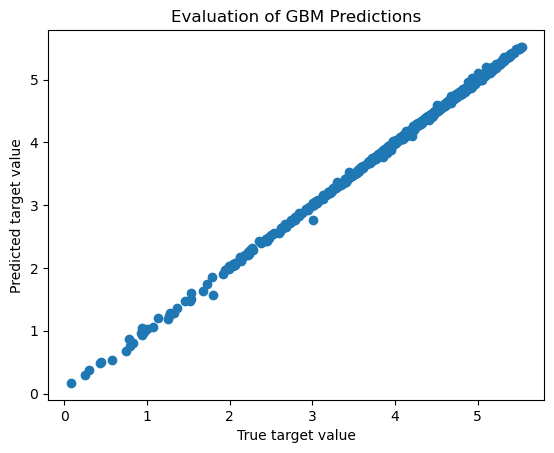

In [23]:
# let's evaluate our predictions respect to the real target value
plt.scatter(y_test, target_Val.predict(X_test))
plt.xlabel('True target value')
plt.ylabel('Predicted target value')
plt.title('Evaluation of GBM Predictions')

The model performance looks great on both train and test data!

In [24]:
# now let's save the pipeline

joblib.dump(target_Val, 'target_Val.joblib') 

['target_Val.joblib']

In [25]:
[target_Val["selector"].get_support()]

[array([ True,  True,  True,  True, False,  True, False,  True,  True,
        False, False, False,  True, False, False, False, False, False,
        False, False,  True, False,  True,  True,  True, False, False,
        False,  True, False,  True,  True,  True, False, False,  True,
        False, False, False, False, False, False, False,  True,  True,
        False,  True,  True, False, False, False, False, False, False,
         True, False, False,  True,  True,  True, False, False, False,
        False, False, False, False, False,  True, False, False, False,
        False, False,  True, False, False, False, False, False])]

# Score new data

In [26]:
#load data
data_features = pd.read_csv("/Users/afanzott/Documents/RHI_Data_Science/research_notebooks/data/md_raw_dataset.csv", sep=";", index_col=False)

#rename first column
data_features.rename(columns = {"Unnamed: 0":"index"}, inplace=True)
data_features.groups = data_features.groups.astype("int64", errors="ignore")

#Cast etherium as numeric

data_features.etherium_before_start = pd.to_numeric(data_features.etherium_before_start, errors="coerce")

cat_vars = [var for var in data_features.columns if data_features[var].dtype == "O"]

cat_vars = cat_vars + ["index", "place", "Unnamed: 7", "human_behavior_report", "groups", "tracking_times"]

# cast all variables as categorical
data_features[cat_vars] = data_features[cat_vars].astype('O')


In [27]:
data = data_features.iloc[0:100, :]

In [28]:
new_preds = target_Val.predict(data)

In [17]:
# let's plot the predicted sale prices
np.exp(new_preds)

array([  1.27227832,   1.95840542,   3.13547628,   4.27349796,
         5.48651977,   7.14455058,   8.40722926,   9.80404653,
        10.94268221,  12.16229187,  13.53050048,  14.70922117,
        15.91309942,  17.07588029,  18.59637114,  19.72629083,
        21.05748598,  21.96779966,  23.25896841,  24.71098266,
        25.84365951,  27.49713993,  29.21004192,  30.00331702,
        31.14105299,  32.1242563 ,  33.4545645 ,  34.18713408,
        35.64685518,  36.85029859,  38.32094041,  39.54961616,
        40.98051157,  42.53533871,  44.19665479,  45.44876505,
        46.1887033 ,  47.74005045,  49.03866839,  50.44000775,
        52.23319105,  53.21719499,  54.25356251,  54.89830592,
        55.83721877,  57.12909368,  58.53527609,  58.68749281,
        61.82844652,  62.02836447,  63.507279  ,  64.47518044,
        66.07365569,  67.52273121,  68.6480146 ,  70.49845032,
        72.54662635,  71.954556  ,  73.50080982,  75.11906701,
        75.82656529,  77.9965613 ,  77.9965613 ,  80.04